# Homework 9

## Utilities 

In [12]:
pip install scikit-learn

     ---------------------------------------- 7.5/7.5 MB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
#Imports Libraries 
# complex networks package - guide https://networkx.org/ 
import networkx as nx

# visualization packages - https://matplotlib.org/ 
import matplotlib.pyplot as plt
%matplotlib inline
from networkx.drawing.nx_agraph import graphviz_layout

# n-dinsional array tool - https://numpy.org/ 
import numpy as np

#import pygraphviz
import seaborn as sns

import matplotlib.colors as mcolors

import sklearn.manifold as sk

import sklearn.cluster as skc

import sklearn.decomposition as skd
import pandas as pd

from node2vec import Node2Vec
# for Notebook
%matplotlib inline

c:\Users\wdaug\Documents\ECE-5260-Graph-Based-Data-Science-for-Networked-Systems\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Question 2

### Ingesting the data 

In [58]:
df_nodes = pd.read_csv('nodes.csv')
df_street = pd.read_csv('streets.csv')
df_nodes.shape #Shows the head of the data

datatypes = df_nodes.dtypes
print(datatypes)

Unnamed: 0        int64
osmid             int64
y               float64
x               float64
highway          object
street_count      int64
ref              object
geometry         object
dtype: object


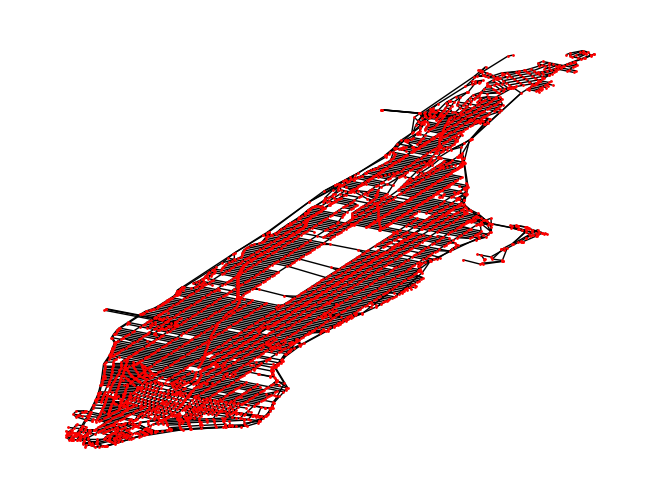

In [45]:
G = nx.Graph() #Creates the empty graph 
for index, row in df_nodes.iterrows(): 
    G.add_node(row['osmid'], pos=(row['x'], row['y'])) #Appends the graph G with the nodes
for index, row in df_street.iterrows():
    G.add_edge(row['u'], row['v'], weight=row['length']) #Appends the graph G with the length for the weights 
    
G.remove_edges_from(nx.selfloop_edges(G)) #Removes the self loops from the graph 

plt.figure() #Creates the figure 
pos = nx.get_node_attributes(G, "pos") #Gets the positional arguement 
nx.draw(G,pos, with_labels=False, node_size=1, node_color='red') #Plots the graph 
plt.show() #Shows the figure 

### skip2gram approach

In [46]:

node2vec = Node2Vec(G, dimensions=32, walk_length=50, num_walks=100 , workers = 8) #Uses the node2vec library 


Computing transition probabilities: 100%|██████████| 4589/4589 [00:00<00:00, 18780.81it/s]


In [48]:
model = node2vec.fit(window=10, min_count=1,batch_words=4) # https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

### Matrix factorization

In [63]:
node_ids =  model.wv.index_to_key
node_ids =list(map(int, node_ids))
node_embeddings = model.wv.vectors #Matrix Factorization

### Plot Network Embeddings 

c:\Users\wdaug\Documents\ECE-5260-Graph-Based-Data-Science-for-Networked-Systems\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\wdaug\Documents\ECE-5260-Graph-Based-Data-Science-for-Networked-Systems\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


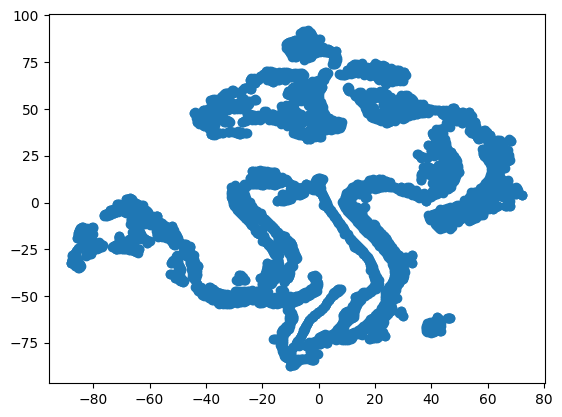

In [52]:
#TSNE 
tsne = sk.TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

plt.scatter(node_embeddings_2d[:,0], node_embeddings_2d[:,1])

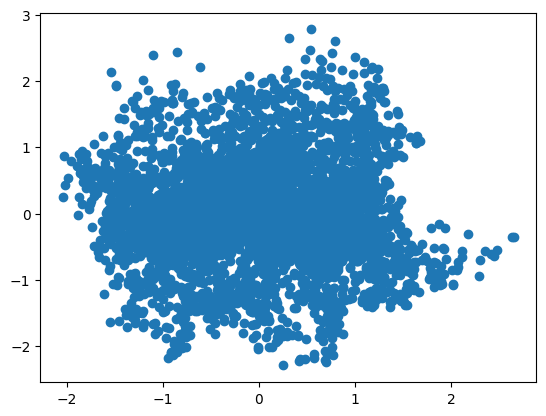

In [55]:
#PCA
pca = skd.PCA(n_components=2)
node_embeddings_2d_2 = pca.fit_transform(node_embeddings)

plt.scatter(node_embeddings_2d_2[:,0], node_embeddings_2d_2[:,1])

### KMeans Clustering 

ConversionError: Failed to convert value(s) to axis units: array(['traffic_signals', 'traffic_signals', 'traffic_signals', ...,
       'traffic_signals', nan, nan], dtype=object)

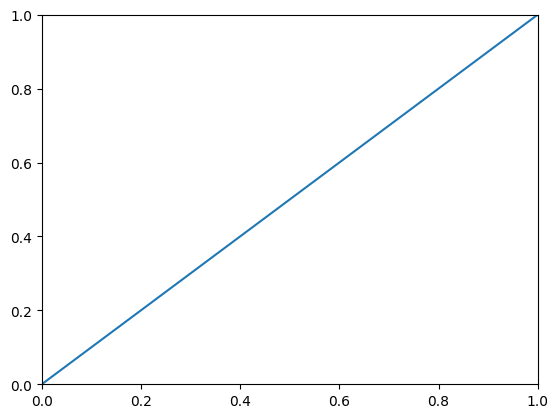

In [65]:

kmeans = skc.KMeans(n_clusters=32, init='k-means++', n_init=10, random_state=0)
kmeans.fit(node_embeddings)

node_cluster_labels = pd.DataFrame(zip(node_ids, kmeans.labels_)).rename(columns={0:'osmid', 1:'cluster_label'})

nodes_clustered = df_nodes.merge(node_cluster_labels, on='osmid')

plt.plot(nodes_clustered)